<a href="https://colab.research.google.com/github/cathemesquita/Colab_notebooks/blob/main/SURROGATOS_IL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


> # BIBLIOTECAS

In [ ]:
pip install open-ephys-python-tools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.8/381.8 kB 6.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for open-ephys-python-tools: filename=open_ephys_python_tools-0.1.7-py3-none-any.whl size=39989 sha256=3c57da52f97fda97a4b764297dd05f0029756e505f58837e338ad59e7de2e797
  Stored in directory: /root/.cache/pip/wheels/99/0a/29/c0d2d399ff078b2a96c61e36a0a219a8fbb545a7acd261ce80
  Created wheel for zmq: filename=zmq-0.0.0-py3-none-any.whl size=1264 sha256=db9dc2c9ed5044e95d44480e277e8838f69403722ca3d0ffa3f137f9e6bccf96
  Stored in directory: /root/.cache/pip/wheels/ab/c5/fe/d853f71843cae26c123d37a7a5934baac20fc66f35a913951d
Successfully built open-ephys-python-tools zmq


In [ ]:
! pip install pactools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 52.5 MB/s eta 0:00:00


In [ ]:
from open_ephys.analysis import Session

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import numpy as np
import pandas as pd


from scipy import signal
import math
from scipy.signal import welch, spectrogram, coherence, find_peaks, firwin, lfilter, filtfilt, hilbert
import seaborn as sn

from statsmodels.tsa.stattools import grangercausalitytests
from scipy import stats
from scipy.stats import wilcoxon

import math
import time as ttime
from numpy.fft import fft, ifft, rfft, fftfreq
from scipy.signal import firwin, lfilter, filtfilt
from scipy.io import loadmat

import pactools
from pactools import Comodulogram, REFERENCES

import seaborn as sns

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen 

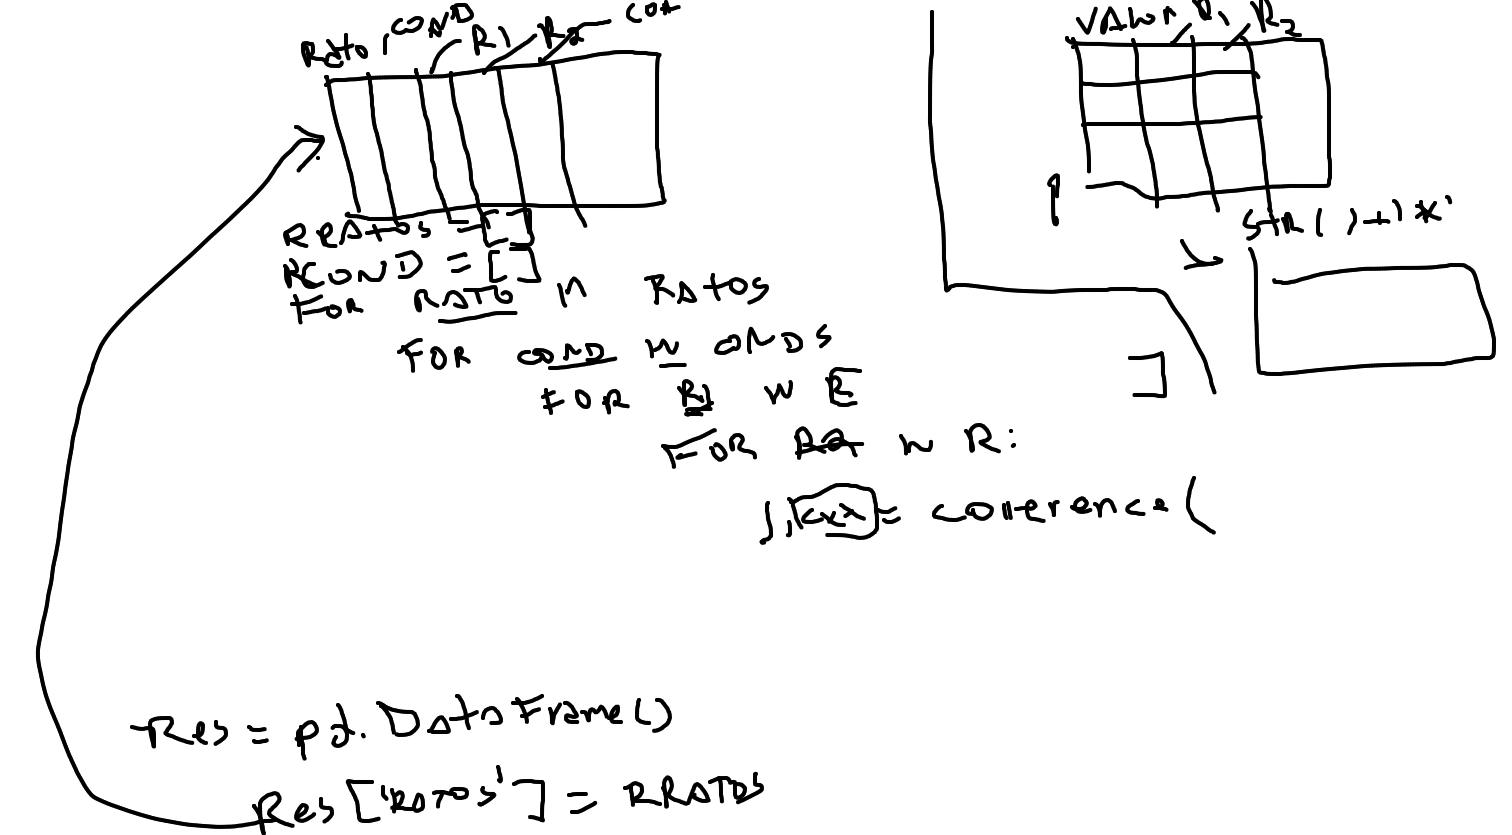

> # FUNÇÕES



In [ ]:
def prewiew(path):
  load = Session(path).recordnodes[0].recordings[0]
  t_raw= load.continuous[0].timestamps
  t = t_raw-t_raw[0]

  data = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t)))

  srate = 1000
  fc_low = 45
  fc_high = 65
  order = 3
  b, a = signal.butter(order, [fc_low/(0.5*srate), fc_high/(0.5*srate)], btype='bandstop')

  data_filt = signal.filtfilt(b, a, data)

  return (pd.DataFrame(data_filt))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def prewiew_plot(data):

  for i in range(0,32):
    plt.figure()
    plt.plot(data[i])
    plt.title('ch' + str (i+1))

In [ ]:
def load_events(path):


  load = Session(path).recordnodes[0].recordings[0]
  event = load.events
  CS = event[(event['line'] ==2)&(event['state']==1)]

  return(pd.DataFrame({'CS': CS}))


In [ ]:
# CARREGAR O DADO E EXTRAIR MOMENTOS DE IMOBILIDADE

def load_data(path,inicio,final,ch_prl,ch_cg,ch_il):
  load = Session(path).recordnodes[0].recordings[0]
  t_raw= load.continuous[0].timestamps
  t = t_raw-t_raw[0]

  # tive que ecolher esse len pq o CCM559 tinha 30 min de dado, então padronizei p todos 10min
  data_prl = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[inicio:final,int(int(ch_prl)-1)]
  data_cg = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[inicio:final,int(int(ch_cg)-1)]
  data_il = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[inicio:final,int(int(ch_il)-1)]


  srate = 1000
  fc_low = 59
  fc_high = 61
  order = 5
  b, a = signal.butter(order, [fc_low/(0.5*srate), fc_high/(0.5*srate)], btype='bandstop')

  PRL = signal.filtfilt(b, a, data_prl)
  CG = signal.filtfilt(b, a, data_cg)
  IL = signal.filtfilt(b, a, data_il)

  return(pd.DataFrame({'data_PRL': PRL,'data_CG': CG, 'data_IL': IL}))

In [ ]:
def media_coherence(df, condicao, r1, r2):
    filtro = (df['condicao'] == condicao) & (df['r1'] == r1) & (df['r2'] == r2)
    media_coherence = df[filtro].groupby('indice')['coherence'].mean()
    result_df = pd.DataFrame({'coherence': media_coherence,'r1': r1,'r2': r2,'condicao': condicao, 'regioes': str(r1)+'->'+str(r2)})
    return (result_df)

In [ ]:
def get_psd( data_psd  ):

  f, p = welch(data_psd, fs = 1000,nperseg = 1000, noverlap = int(0.9*1000), nfft = 10*1000)
  df_psd = pd.DataFrame({'PSD': p, 'F': f})

  return(df_psd )

In [ ]:
# Função para mapear o valor da frequencia da coerencia para o nome da banda
def mapear_banda(valor):
    if 0 <= valor <= 4:
        return 'Delta'
    elif 5 <= valor <= 10:
        return 'Theta'
    elif 11 <= valor <= 29:
        return 'Alpha/beta'
    elif 30 <= valor <= 50:
        return 'Low gamma'
    elif 51 <= valor <= 90:
        return 'Mid gamma'
    else:
        return 'High gamma'

In [ ]:
def tempo_para_pontos(tempo):
    minutos, segundos = map(int, tempo.split(':'))
    total_segundos = minutos * 60 + segundos
    pontos = total_segundos * 1000
    return pontos

In [ ]:

def eegfilt(data,srate,flow,fhigh):

    # fir LS
    trans = 0.15
    nyq = srate*0.5
    f=[0, (1-trans)*flow/nyq, flow/nyq, fhigh/nyq, (1+trans)*fhigh/nyq, 1]
    m=[0,0,1,1,0,0]
    filt_order = 3*np.fix(srate/flow)
    if filt_order % 2 == 0:
        filt_order = filt_order + 1

    filtwts = signal.firls(filt_order,f,np.double(m))
    data_filt = signal.filtfilt(filtwts,1, data)

    return(data_filt)

In [ ]:
#ExTRAINDO O MODULATION INDEX

def modulation_index(amp,fase_lenta,numbin):

    position=np.zeros(numbin) # this variable will get the beginning (not the center) of each phase bin (in rads)
    winsize = 2*np.pi/numbin # bin de fase

    position = []
    for j in np.arange(1,numbin+1):
        position.append(-np.pi+(j-1)*winsize)

    nbin=numbin
    mean_amp = []
    for j in np.arange(0,nbin):
        boolean_array = np.logical_and(fase_lenta >=  position[j], fase_lenta < position[j]+winsize)
        I = np.where(boolean_array)[0]
        mean_amp.append(np.mean(amp[I]))

    mean_amp = [x for x in mean_amp if str(x) != 'nan']
    p = mean_amp/np.sum(mean_amp)

    entrop = -1*(np.sum(p*np.log(p)))
    mi = (np.log(numbin)-entrop)/np.log(numbin)

    return(mi)

In [ ]:
import random

def generating_surrogatos(lfp,numero_surrogatos):
    surrogatos = []
    for i in range(numero_surrogatos):
        split = random.randint(1, 90000)
        surro = np.concatenate([lfp[split:], lfp[:split]])
        surrogatos.append(surro)
    return surrogatos

In [ ]:
# ACOP FASE AMPL PARA UMA REGIÃO

def pac(lfp,lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,srate,numbin):

    AmpFreqTransformed1 = []
    PhaseFreq = []

    pac_mi = []

    for ii in altaVector:
        Af1 = ii
        Af2=Af1+alta_BandWidth

        AmpFreq1=eegfilt(lfp,srate,Af1,Af2) # just filtering

        analytic_signal1 = signal.hilbert(AmpFreq1)
        AmpFreqTransformed1.append(np.abs(analytic_signal1))

    faselenta = []
    for jj in lentaVector:
        Pf1 = jj
        Pf2 = Pf1 + lenta_BandWidth
        PhaseFreq=eegfilt(lfp,srate,Pf1,Pf2)
        analytic_signal = signal.hilbert(PhaseFreq)
        faselenta.append(np.angle(analytic_signal))

    fase_lenta = faselenta

    comodulogram = np.empty((len(lentaVector),len(altaVector)))

    for count_lenta,lenta in enumerate(fase_lenta):

        for count_rapida,rapida in enumerate(AmpFreqTransformed1):

            comodulogram[count_lenta,count_rapida] = modulation_index(rapida,lenta,numbin)


    return(comodulogram)

In [ ]:
# ACOP FASE AMPL ENTRE DUAS REGIÕES

def pac_entre_regioes(lfp_alta,lfp_lenta,lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,srate,numbin):

    AmpFreqTransformed1 = []
    PhaseFreq = []

    pac_mi = []

    for ii in altaVector:
        Af1 = ii
        Af2=Af1+alta_BandWidth

        AmpFreq1=eegfilt(lfp_alta,srate,Af1,Af2) # just filtering

        analytic_signal1 = signal.hilbert(AmpFreq1)
        AmpFreqTransformed1.append(np.abs(analytic_signal1))


    faselenta = []
    for jj in lentaVector:
        Pf1 = jj
        Pf2 = Pf1 + lenta_BandWidth
        PhaseFreq=eegfilt(lfp_lenta,srate,Pf1,Pf2)
        analytic_signal = signal.hilbert(PhaseFreq)
        faselenta.append(np.angle(analytic_signal))


    fase_lenta = faselenta

    comodulogram = np.empty((len(lentaVector),len(altaVector)))


    for count_lenta,lenta in enumerate(fase_lenta):

        for count_rapida,rapida in enumerate(AmpFreqTransformed1):

            comodulogram[count_lenta,count_rapida] = modulation_index(rapida,lenta,numbin)


    return(comodulogram)

In [ ]:

def phase_amp_hist(amp,fase_lenta,numbin):

    position=np.zeros(numbin) # this variable will get the beginning (not the center) of each phase bin (in rads)
    winsize = 2*np.pi/numbin # bin de fase

    position = []
    for j in np.arange(1,numbin+1):
        position.append(-np.pi+(j-1)*winsize)


    nbin=numbin
    mean_amp = []
    for j in np.arange(0,nbin):
        boolean_array = np.logical_and(fase_lenta >=  position[j], fase_lenta < position[j]+winsize)
        I = np.where(boolean_array)[0]
        mean_amp.append(np.mean(amp[I]))

    mean_amp = [x for x in mean_amp if str(x) != 'nan']
    p = mean_amp/np.sum(mean_amp)

    return(p)


def pac_histogram(lfp_amp,lfp_fase,altaVector,lenta_BandWidth,alta_BandWidth,srate,numbin):

    AmpFreqTransformed1 = []

    for ii in altaVector:
        Af1 = ii
        Af2=Af1+alta_BandWidth

        AmpFreq1=eegfilt(lfp_amp,srate,Af1,Af2) # just filtering

        analytic_signal1 = signal.hilbert(AmpFreq1)
        AmpFreqTransformed1.append(np.abs(analytic_signal1))

    Pf1 = 4
    Pf2 = 12
    PhaseFreq=eegfilt(lfp_fase,srate,Pf1,Pf2)
    analytic_signal = signal.hilbert(PhaseFreq)
    faselenta = np.angle(analytic_signal)

    hist_freqs = []

    for count_rapida,rapida in enumerate(AmpFreqTransformed1):

        hist_freqs.append(phase_amp_hist(rapida,faselenta,numbin))


    return(hist_freqs)


> # ANÁLISE DOS DADOS

NormAmp = (Amp - min(Amp)) / (max(Amp) - min(Amp)))  [texto do link](https://www.frontiersin.org/articles/10.3389/fncir.2017.00029/full)

In [ ]:
ratos = { 'CCM497': { 'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/16_12_22/CCM497_OF_PRE_SCREEN',
                                   'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/16_12_22/CCM497_OF_POS_SCREEN'},

                      'canais': {'prl': 26,
                                  'cg': 14,
                                  'il': 3},

                      'inicio': { 'OF_pre': 50000,
                                  'OF_pos': 5000} ,  # VERIFICADO OF PRE E POS OK

                      'screening': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/16_12_22/CCM497_SCREENING'   },

         'CCM559': {'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/16_12_22/CCM559_OF_PRE_SCREEN',
                                 'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/16_12_22/CCM559_OF_POS_SCREEN'},

                    'canais': {'prl': 28,
                               'cg': 22,
                               'il': 7 },

                    'inicio': { 'OF_pre': 390000,
                                'OF_pos': 205000    },

                    'screening': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/16_12_22/CCM559_SCREENING'    },

          # 'CCM56': {'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/09_08_23/CCM56_OF_PRE_SCREEN',
          #                        'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/09_08_23/CCM56_OF_POS_SCREEN' },

          #           'canais': { 'prl': 4,
          #                       'cg': 6,
          #                       'il': 24 },

          #           'inicio': { 'OF_pre': 40000,
          #                       'OF_pos': 140000   } ,
          #            'screening': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/09_08_23/CCM56_SCREENING'},

          'CCM04': {'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/29_08_23/CCM04_OF_PRE_SCREEN',
                                 'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/29_08_23/CCM04_OF_POS_SCREEN' },

                    'canais': { 'prl': 21 ,
                                'cg': 29,
                                'il': 25 },

                    'inicio': { 'OF_pre': 10000,
                               'OF_pos': 490000   } ,

                    'screening': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/29_08_23/CCM04_SCREENING'     },

          'CCM05': {'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/31_08_23/CCMO5_OF_PRE_SCREEN',
                                'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/31_08_23/CCM05_OF_POS_SCREEN_2' },

                    'canais': { 'prl':22 ,
                                'cg':29 ,
                                'il':27  },

                    'inicio': { 'OF_pre': 590000 ,
                                'OF_pos':  242000  } ,

                     'screening':  '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/31_08_23/CCMO5_SCREENING'},

          'CCM192': {'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/26_10_2023/CCM192_OF_PRE_SCREEN',
                                  'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/26_10_2023/CCM192_OF_POS_SCREEN' },

                      'canais': { 'prl': 24,
                                 'cg': 31,
                                 'il': 27},

                      'inicio': { 'OF_pre': 136000 ,
                                  'OF_pos':  170000  } ,        # VERIFICADO OF PRE E POS OK

                       'screening': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/26_10_2023/CCM192_SCREENING'},

          'CCM193': {'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/31_10_2023/CCM193_OF_PRE_SCREEN',
                                'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/31_10_2023/CCM193_OF_POS_SCREEN' },

                    'canais': { 'prl': 21 ,
                                'cg': 29,
                                'il': 28},

                    'inicio': { 'OF_pre': 200000,
                                'OF_pos':  390000 } ,   # VERIFICADO OF PRE E POS OK

                    'screening': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/31_10_2023/CCM193_SCREENING'} }

In [ ]:
# CRIANDO DF COM OS DADOS

dataframes = []
for rato in ratos.keys():
  for condicao in ratos[rato]['condicao'].keys():
      path = ratos[str(rato)]['condicao'][str(condicao)]
      inicio = ratos[str(rato)]['inicio'][str(condicao)]
      final = inicio + 90000

      ch_prl =  ratos[rato]['canais']['prl']
      ch_cg =  ratos[rato]['canais']['cg']
      ch_il =  ratos[rato]['canais']['il']

      df_temp = load_data(path,inicio,final, ch_prl, ch_cg, ch_il)
      df_temp['animal'] = str(rato)
      df_temp['condicao'] = str(condicao)

      dataframes.append(df_temp)

df = pd.concat(dataframes)

/usr/local/lib/python3.10/dist-packages/open_ephys/analysis/formats/BinaryRecording.py:141: ResourceWarning: unclosed file <_io.TextIOWrapper name='/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/16_12_22/CCM497_OF_PRE_SCREEN/Record Node 101/experiment1/recording1/structure.oebin' mode='r' encoding='UTF-8'>
  self.info = json.load(open(os.path.join(self.directory, 'structure.oebin')))
/usr/local/lib/python3.10/dist-packages/open_ephys/analysis/formats/BinaryRecording.py:141: ResourceWarning: unclosed file <_io.TextIOWrapper name='/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/16_12_22/CCM497_OF_PRE_SCREEN/Record Node 101/experiment1/recording2/structure.oebin' mode='r' encoding='UTF-8'>
  self.info = json.load(open(os.path.join(self.directory, 'structure.oebin')))
/usr/local/lib/python3.10/dist-packages/open_ephys/analysis/formats/BinaryRecording.py:141: ResourceWarning: unclosed file <_io.TextIOWrapper name='/content/drive/Shareddrives/Stress 1K/PROJETO 


# > PAC na mesma região

⚠ revisar papers:

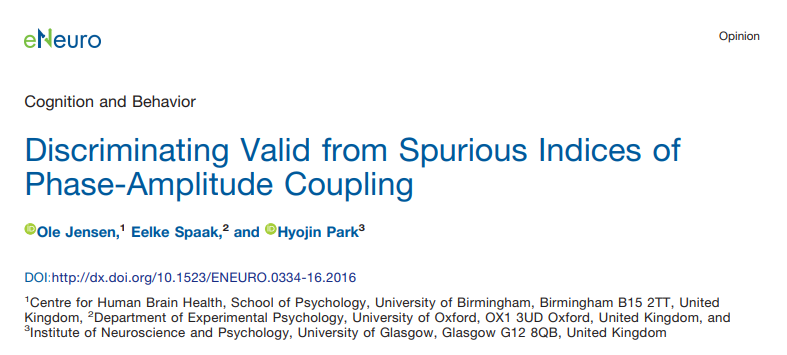

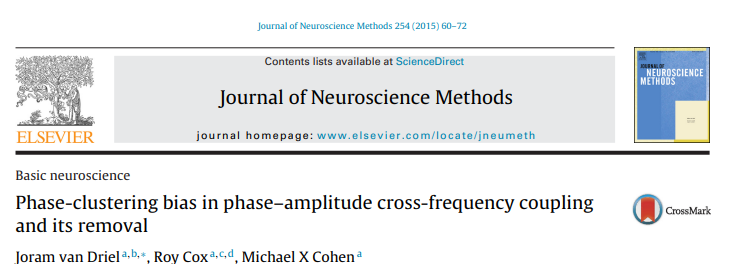

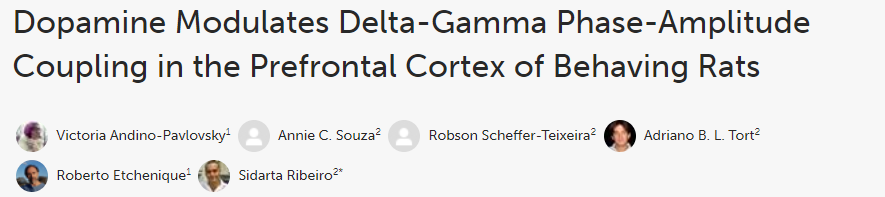

In [ ]:
data_prl_pre = []
data_prl_pos = []
data_cg_pre = []
data_cg_pos = []
data_il_pre = []
data_il_pos = []

for rato in ratos.keys():


  il_pre = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pre')]['data_IL']
  data_il_pre.append(il_pre)

  il_pos = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pos')]['data_IL']
  data_il_pos.append(il_pos)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# CRIANDO SURROGATOS POR REGIÃO: IL PRE

lentaVector = np.arange(1,10,1) # bins para as ondas lentas (onde serão retiradas as fases)
altaVector = np.arange(30,150,10) # bins para as ondas rápidas (onde serão retiradas as amplitudes)
lenta_BandWidth = 2 # resolução para as lentas
alta_BandWidth = 10 # resolução para as rápidas
numbin = 18 #esse numero é fixo, manter sempre 18
numero_surrogatos = 300 #quantidade de surrogatos que vão ser gerados

n_animals = 6

surrogatos = []
pac_il_pre_all = []

# calculando os pacs para os surrogatos

for i in range(n_animals):
  pac_il_pre = []
  lfp = data_il_pre[i]
  surrogato = generating_surrogatos(lfp, numero_surrogatos)
  for j in range(numero_surrogatos):
    faz_pac_il_pre = pac(surrogato[j],lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin)
    pac_il_pre.append(faz_pac_il_pre)

  pac_il_pre_all.append(pac_il_pre)



In [ ]:
# CRIANDO SURROGATOS POR REGIÃO: IL POS

lentaVector = np.arange(1,10,1) # bins para as ondas lentas (onde serão retiradas as fases)
altaVector = np.arange(30,150,10) # bins para as ondas rápidas (onde serão retiradas as amplitudes)
lenta_BandWidth = 2 # resolução para as lentas
alta_BandWidth = 10 # resolução para as rápidas
numbin = 18 #esse numero é fixo, manter sempre 18
numero_surrogatos = 300 #quantidade de surrogatos que vão ser gerados

n_animals = 6

surrogatos = []
pac_il_pos_all = []

# calculando os pacs para os surrogatos

for i in range(n_animals):
  pac_il_pos = []
  lfp = data_il_pos[i]
  surrogato = generating_surrogatos(lfp, numero_surrogatos)
  for j in range(numero_surrogatos):
    faz_pac_il_pos = pac(surrogato[j],lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin)
    pac_il_pos.append(faz_pac_il_pos)

  pac_il_pos_all.append(pac_il_pos)




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
